In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *
from networks import *

from utilities import *
from parse_dataset import *

In [2]:
# %load_ext autoreload
# %autoreload 2

# Loading the dataset

In [3]:
folder=Dataset(base_directory='/home/stefano/',dataset='eeg')

Reading data from /home/stefano/EEG//
Reading data from /home/stefano/EEG//stored//
Reading data from /home/stefano/EEG//__pycache__//
Reading data from /home/stefano/EEG//data//
Reading data from /home/stefano/EEG//stefano//
Reading data from /home/stefano/EEG//stefano//__pycache__//
Reading data from /home/stefano/EEG//stefano//notebook//


In [4]:
# train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [5]:
# test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [6]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [7]:
test_dataset,test_target=load_script.load_dataset(train=False)

# Normalization

In [8]:
train_dataset.shape

torch.Size([316, 28, 50])

In [9]:
test_dataset.shape

torch.Size([100, 28, 50])

In [10]:
mean=train_dataset.mean(0).view(1,28,50)
std=train_dataset.std(0).view(1,28,50)

In [11]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

# Training

  0%|          | 0/400 [00:00<?, ?it/s]

Dropout 0
42.0
Network:

[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [00:53<00:00,  7.36it/s]


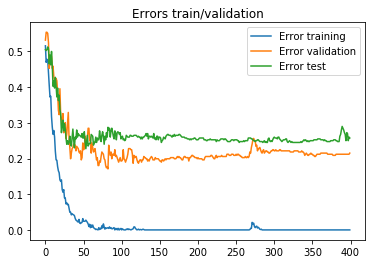

  0%|          | 0/400 [00:00<?, ?it/s]

Performance train: 0.0
Performance validation: 0.215443037975
Performance test: 0.2529
Dropout 0.1
42.0
Network:

[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:15<00:00,  5.62it/s]


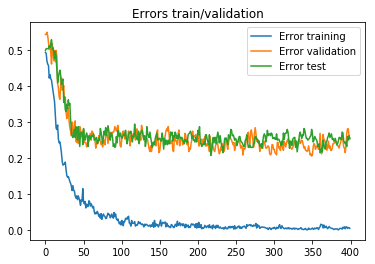

  0%|          | 1/400 [00:00<00:56,  7.05it/s]

Performance train: 0.00487341772152
Performance validation: 0.236234177215
Performance test: 0.2516
Dropout 0.2
42.0
Network:

[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:15<00:00,  3.37it/s]


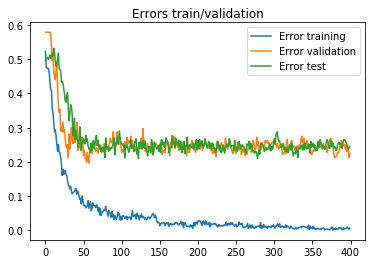

  0%|          | 0/400 [00:00<?, ?it/s]

Performance train: 0.00709915611814
Performance validation: 0.242879746835
Performance test: 0.246725
Dropout 0.3
42.0
Network:

[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:18<00:00,  5.15it/s]


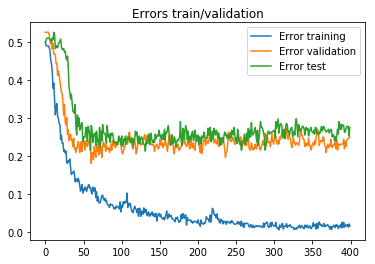

  0%|          | 1/400 [00:00<00:52,  7.59it/s]

Performance train: 0.0149050632911
Performance validation: 0.238259493671
Performance test: 0.268025
Dropout 0.4
42.0
Network:

[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:16<00:00,  5.63it/s]


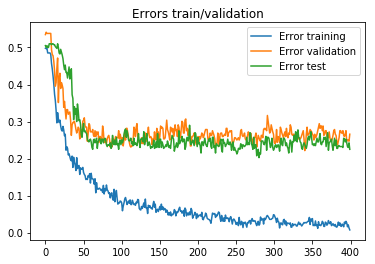

  0%|          | 1/400 [00:00<01:05,  6.11it/s]

Performance train: 0.0242299578059
Performance validation: 0.263860759494
Performance test: 0.242675
Dropout 0.5
42.0
Network:

[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:18<00:00,  5.43it/s]


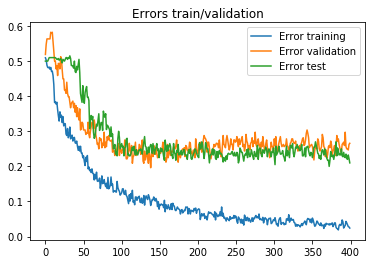

  0%|          | 1/400 [00:00<00:48,  8.29it/s]

Performance train: 0.0377109704641
Performance validation: 0.260569620253
Performance test: 0.238425
Dropout 0.6
42.0
Network:

[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:22<00:00,  5.22it/s]


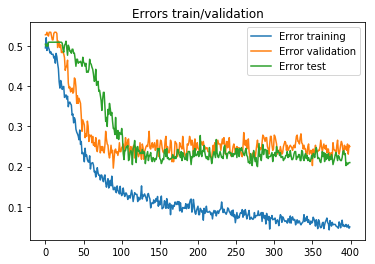

  0%|          | 1/400 [00:00<01:00,  6.60it/s]

Performance train: 0.0609071729958
Performance validation: 0.24667721519
Performance test: 0.224625
Dropout 0.7
42.0
Network:

[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 400/400 [01:21<00:00,  5.17it/s]


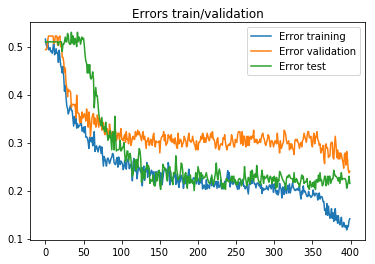

  0%|          | 1/400 [00:00<00:42,  9.31it/s]

Performance train: 0.178291139241
Performance validation: 0.292183544304
Performance test: 0.221675
Dropout 0.8
42.0
Network:

[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[1176, 200]
[200, 2]

Repetition 0


 27%|██▋       | 109/400 [00:15<00:41,  7.06it/s]

In [ ]:
dropout_values=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results=[]
for dropout in dropout_values:
    print('Dropout',dropout)
    cv=CrossValidation(k=4,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)
    
    net_type=FourLayers
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[3,3,3],
                                 linear_filters=[200,2],
                                 dropout_rate=dropout,batch_norm=True,conv1D=True)
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=400,mini_batch_size=79)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,)

    cv(params,repetitions=1,cross_validation=True,repetitions_test=4)
    results.append(cv.result)

In [ ]:
save=False
if save:
    file_name=folder.stored+'three_layers'
    write_pickle(results,file_name)

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[(3,1),(5,3),(3,3)],
                             linear_filters=[200,2],
                             dropout_rate=0,batch_norm=False,conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100,mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2],dropout_rate=0)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train(train_dataset=train_dataset,test_dataset=test_dataset,
            train_target=train_target,test_target=test_target)
train(params)